## Pump it Up: Data Mining the Water Table

_ http://www.drivendata.org/competitions/7/page/25/ _ 
> "Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all?"

In [114]:
import pandas as pd
workdir = "F:/Datasets/1-DataMiningTheWaterTable/"

In [115]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [116]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [117]:
#pd.set_option('display.width', 500)
#pd.set_option('display.max_columns', 100)

In [118]:
traindata = pd.read_csv(workdir+'Training_set_values.csv')
traindatalabels = pd.read_csv(workdir+'Training_set_labels.csv')

Merging labels on the training set

In [119]:
traindata = traindata.merge(traindatalabels, on="id", how='left')

In [120]:
traindata.shape

(59400, 41)

In [121]:
#Description of numerical columns
traindata.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [122]:
traindata.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


To simplify the EDA we'll delete redundant columns

#### Remove redundant columns. We'll leave only one column of each of this groups:
- extraction_type, extraction_type_group, extraction_type_class - The kind of extraction the waterpoint uses
- management, management_group - How the waterpoint is managed
- payment, payment_type - What the water costs
- water_quality, quality_group - The quality of the water
- quantity, quantity_group - The quantity of water
- source, source_type, source_class - The source of the water
- waterpoint_type, waterpoint_type_group - The kind of waterpoint

In [123]:
traindata.drop(["extraction_type", "extraction_type_class", "payment", "quality_group", "quantity_group", "scheme_name", "source_type", "waterpoint_type"], axis=1, inplace=True)

Removing metadata about the records

In [124]:
traindata.drop(["date_recorded"], axis=1, inplace=True)

Removing redundant geographic information

In [125]:
traindata.drop(["subvillage", "lga", "ward"], axis=1, inplace=True)

Separating the id column

In [126]:
traindata_id = traindata["id"]

In [127]:
traindata.drop(["id"], axis=1, inplace=True)

In [128]:
traindata.shape

(59400, 28)

In [129]:
traindata.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,...,extraction_type_group,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type_group,status_group
0,6000,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Iringa,...,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,functional
1,0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Mara,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Manyara,...,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe,functional
3,0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mtwara,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe,non functional
4,0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kagera,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [130]:
categorical = ['funder',  'installer', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit',  'extraction_type_group', 'management', 'management_group', 'payment_type', 'water_quality', 'quantity', 'source', 'source_class', 'waterpoint_type_group', "wpt_name", "recorded_by"]

Summary of categorical data

In [131]:
traindata[categorical].describe()

,funder,installer,basin,region,public_meeting,scheme_management,permit,extraction_type_group,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type_group,wpt_name,recorded_by
count,55765,55745,59400,59400,56066,55523,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1897,2145,9,21,2,12,2,13,12,5,7,8,5,10,3,6,37400,1
top,Government Of Tanzania,DWE,Lake Victoria,Iringa,True,VWC,True,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe,none,GeoData Consultants Ltd
freq,9084,17402,10248,5294,51011,36793,38852,26780,40507,52490,25348,50818,33186,17021,45794,34625,3563,59400


### Data cleaning

We'll delete the columns where there is a majority of missing data, or where there is only one value

In [132]:
traindata.drop(["wpt_name", "recorded_by", "num_private", 'permit', 'public_meeting', 'scheme_management', ], axis=1, inplace=True)

In [133]:
traindata.shape

(59400, 22)

#### Checking numerical values

In [134]:
numerical = ["amount_tsh", "gps_height", "longitude", "latitude", "population", "construction_year"]

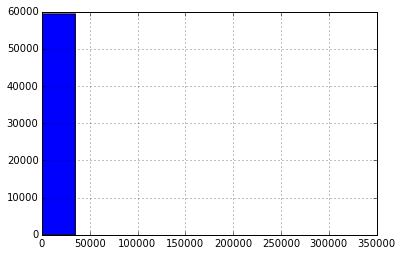

In [135]:
traindata["amount_tsh"].hist()

There are some extreme values. We'll delete some of the outliers (less than 0.1%)

In [136]:
traindata[traindata["amount_tsh"]>20000].shape

(52, 22)

In [137]:
traindata = traindata[traindata["amount_tsh"]<20000]

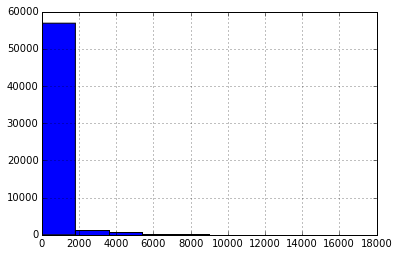

In [138]:
traindata["amount_tsh"].hist()

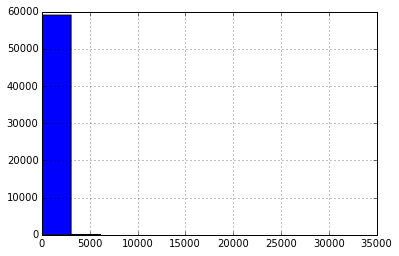

In [139]:
traindata["population"].hist()

We'll delete the most extreme of the outliers

In [140]:
traindata[traindata["population"]>10000].shape

(3, 22)

In [141]:
traindata = traindata[traindata["population"]<10000]

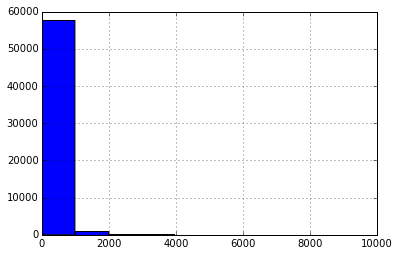

In [142]:
traindata["population"].hist()

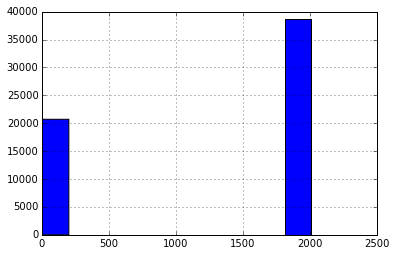

In [143]:
traindata["construction_year"].hist()

There is a lot of missing data for the construction year. However the absence of data could be a useful indicator of the management of the pump, and there is not an obvious interpolation that could be done, so we'll leave the values

This is the histogram without the missing values

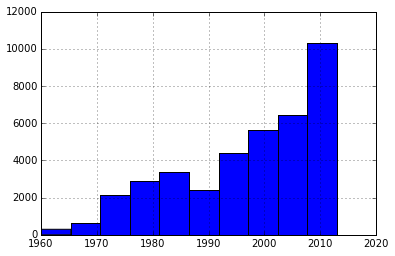

In [144]:
traindata[traindata["construction_year"]>1]["construction_year"].hist()

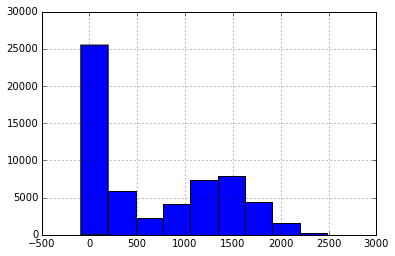

In [145]:
traindata["gps_height"].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003BFF60F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000049290668>]], dtype=object)

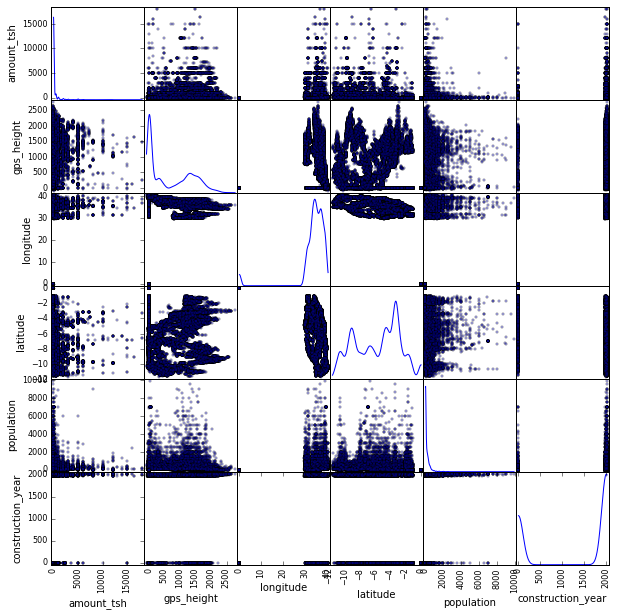

In [146]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(traindata[numerical], alpha=0.3, figsize=(10, 10), diagonal='kde')

#### Checking categorical values

In [147]:
categorical = ['funder',  'installer', 'basin', 'region', 'extraction_type_group', 'management', 'management_group', 'payment_type', 'water_quality', 'quantity', 'source', 'source_class', 'waterpoint_type_group']
traindata[categorical].describe()

,funder,installer,basin,region,extraction_type_group,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type_group
count,55666,55646,59297,59297,59297,59297,59297,59297,59297,59297,59297,59297,59297
unique,1896,2143,9,21,13,12,5,7,8,5,10,3,6
top,Government Of Tanzania,DWE,Lake Victoria,Iringa,gravity,vwc,user-group,never pay,soft,enough,spring,groundwater,communal standpipe
freq,9077,17355,10244,5269,26719,40450,52413,25343,50717,33108,16976,45731,34533


It could be difficult to work with categorical data where the number of categories is too high. 'installer' and 'funder' have more than 2000 classes each

In [148]:
traindata.drop(["installer", "funder"], axis=1, inplace=True)

In [149]:
traindata.shape

(59297, 20)

## Creating a classification model

Separating the labels vector

In [150]:
Y = traindata.status_group
traindata.drop("status_group", axis=1, inplace=True)

Processing categorical data. We'll convert categorical data to “one-hot” binary representation

In [151]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler

In [152]:
categorical = ['basin', 'region', 'extraction_type_group', 'management', 'management_group', 'payment_type', 'water_quality', 'quantity', 'source', 'source_class', 'waterpoint_type_group', 'region_code', 'district_code']

In [153]:
vec = DictVectorizer()
vec.fit(traindata[categorical].T.to_dict().values())
tr_cat = vec.transform(traindata[categorical].T.to_dict().values()).todense()

In [154]:
sum(np.isnan(tr_cat))

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Next we'll scale numerical data

In [155]:
min_max_scaler = MinMaxScaler()
tr_num = min_max_scaler.fit_transform(traindata[numerical].as_matrix())

This is the new representation of the dataset for the machine learning models:

In [156]:
import numpy as np
X = np.hstack((tr_num, tr_cat))

In [157]:
X

matrix([[ 0.33333333,  0.51748252,  0.86597907, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.52062937,  0.8600471 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00138889,  0.27132867,  0.92850378, ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.03146853,  0.84315093, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.03146853,  0.88886216, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.09825175,  0.94445076, ...,  1.        ,
          0.        ,  0.        ]])

Creating a validation set: a random 20% subset of the data

In [158]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Creating a simple classification model

In [170]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(n_estimators = 5)
model1 = model1.fit(X_train, y_train)

Checking metrics of the model

In [171]:
from sklearn.metrics import classification_report, accuracy_score

In [172]:
y_pred = model1.predict(X_test)

In [173]:
print accuracy_score(y_test, y_pred)

0.777824620573


In [174]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

 functional       0.79      0.85      0.82      6367
functional needs repair       0.43      0.31      0.36       869
non functional       0.81      0.77      0.79      4624

avg / total       0.77      0.78      0.77     11860



77.8% accuracy is not a bad score, but it could be better. 

We'll try with a more complex classification model, a random forest with more trees

In [176]:
model2 = RandomForestClassifier(n_estimators = 50)
model2 = model2.fit(X_train, y_train)

In [177]:
y_pred = model2.predict(X_test)

In [178]:
print accuracy_score(y_test, y_pred)

0.797133220911


In [179]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

 functional       0.80      0.88      0.84      6367
functional needs repair       0.50      0.31      0.38       869
non functional       0.83      0.78      0.80      4624

avg / total       0.79      0.80      0.79     11860



79.7% accuracy is better

More importan in this context could be the recall of non-functional water pumps, because such a situation can cause serious problems to a community. Here we are finding 78% of non functional pumps, which is pretty good.

We'll try giving more weight to the class non-funcional

In [198]:
model3 = RandomForestClassifier(n_estimators = 50, 
                                class_weight={'functional':1, 'functional needs repair': 1, 'non functional':2})
model3 = model2.fit(X_train, y_train)

In [199]:
y_pred = model3.predict(X_test)

In [200]:
print accuracy_score(y_test, y_pred)

0.798819561551


In [201]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

 functional       0.80      0.88      0.84      6367
functional needs repair       0.51      0.30      0.37       869
non functional       0.83      0.78      0.81      4624

avg / total       0.79      0.80      0.79     11860



Now accuracy is slightly better at 79.9%, but the recall of non-funcional pumps is the same

However, we now have a model that can classify correctly the status of 80% of community water pumps, which could be used by NGOs or the government to better focus their resources 